In [808]:
import pandas as pd
import random
import numpy as np
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import unicodedata
#import inflect
import re
from itertools import chain
#!pip install contractions
#import contractions
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

#prabesh being stupid sunday morning
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
import gensim





import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/mina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


ModuleNotFoundError: No module named 'gensim'

In [905]:
#load in the csv contatining the data
df_original = pd.read_csv('wiki_movie_plots_deduped.csv')

In [906]:
# drop unknown values and unneccessary columns
df_all = df_original.drop(df_original[df_original['Genre'] == "unknown"].index, 
                          inplace = False)
df_all = df_all.drop(['Release Year','Origin/Ethnicity','Cast', 'Wiki Page','Director',
                      'Release Year'],axis=1,)

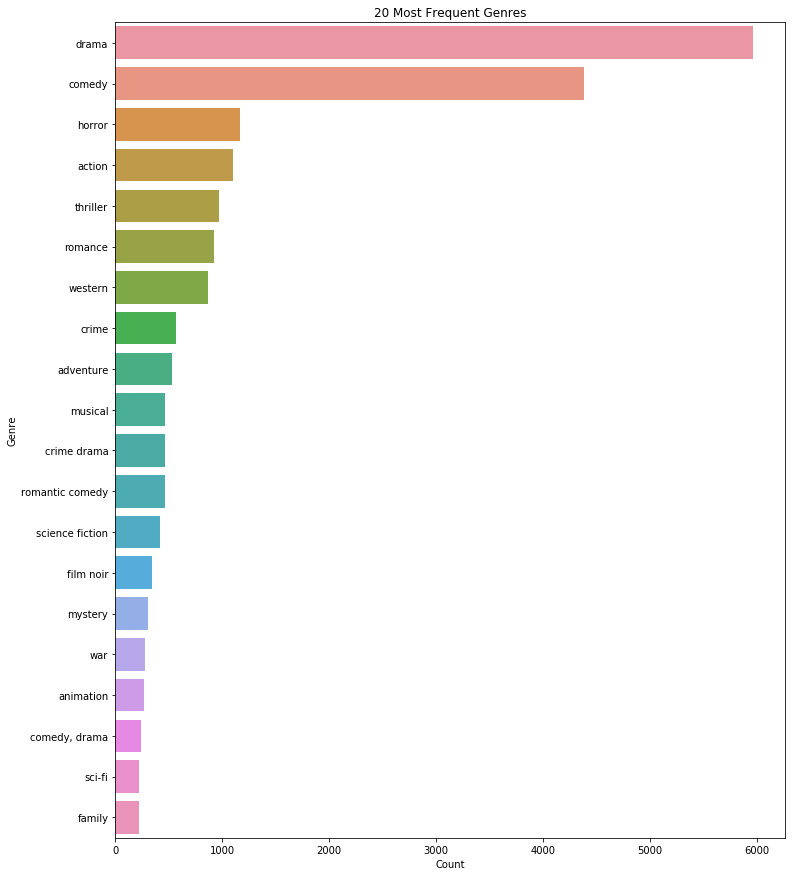

In [907]:
# Most popular genres

genres = []
for g in df_all['Genre']:
    genres.append(g)

genres = nltk.FreqDist(genres) 
genres_df = pd.DataFrame({'Genre':list(genres.keys()), 'Count':list(genres.values())}) 
  
d = genres_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=d, x= "Count", y = "Genre") 
ax.set(ylabel = 'Genre') 
plt.title("20 Most Frequent Genres")
plt.show()

In [908]:
# df containing top 

In [909]:
#Function to create dataframes for each genre; using 1000 elements for training 
def dataframe_creator(genre):
    genre = df_original.drop(df_original[df_original['Genre'] != genre].index, inplace = False)
    genre.drop(['Release Year','Origin/Ethnicity','Cast', 'Wiki Page','Director','Release Year'],axis=1, 
               inplace = True)
    genre = genre.sample(frac=1)
    genre = genre.reset_index(drop=True)
    genre_train = genre[:int(0.5*len(genre))]
    genre_test = genre[int(0.5*len(genre)):]
    return (genre_train,genre_test)

In [910]:
#List of Genres we want to run analysis on
df_horror_train, df_horror_test = dataframe_creator('horror')
df_comedy_train, df_comedy_test = dataframe_creator('comedy')
df_drama_train, df_drama_test = dataframe_creator('drama')
df_action_train, df_action_test = dataframe_creator('action')
df_thriller_train, df_thriller_test = dataframe_creator('thriller')
df_romance_train, df_romance_test = dataframe_creator('romance')
df_western_train, df_western_test = dataframe_creator('western')
df_crime_train, df_crime_test = dataframe_creator('crime')


#Creating dataframes for all genres for training
df_train = pd.concat([df_horror_train,df_comedy_train, df_drama_train,df_action_train,df_thriller_train,df_romance_train,df_western_train, df_crime_train])
#df_train = pd.concat([df_horror_train,df_comedy_train,])

#creating dataframes for all genres for testing
df_test = pd.concat([df_horror_test,df_comedy_test, df_drama_test,df_action_test,df_thriller_test,df_romance_test,df_western_test, df_crime_test])
#df_test = pd.concat([df_horror_test,df_comedy_test])

In [911]:
# Check word type of a word
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [912]:
#Function for text pre-processing
def normalizeText(row):
    
    #create a list of punctuations we wish to delete
    punctuations = string.punctuation
    #create a list of stopwords in English
    stopWords = set(stopwords.words('english'))
    
    #change all letters to lower case
    row = row.lower()  
    
    #remove numbers
    row = re.sub(" \d+", " ", row)
                 
    #remove punctutation
    for letter in row: 
    
        if letter in punctuations: 
            row = row.replace(letter, "")
    
    #expand the contraction I'm -> I am
    #row = contractions.fix(row)
    # got it from (https://github.com/kootenpv/contractions)
                
    #remove accent char
    row = unicodedata.normalize('NFKD', row).encode('ascii', 'ignore').decode('utf-8', 'ignore')
                 
    #remove extra whitespace convert into a word  
    row = row.strip()
    
    # TOKENIZATION: process of splitting text into smaller piece called tokens.
    tokens = word_tokenize(row)
    
    # lemmatization step played -> play
    lemmatizer = WordNetLemmatizer()
    row = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(row)])
    
    #remove stop words such as "a", "the", "is"
    tokens = word_tokenize(row)
    row = ' '.join([i for i in tokens if not i in stopWords])
     
    return row

In [913]:
# print most common words in df
def wordFrequency(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.title("Most Frequent Words")
    plt.show()
  


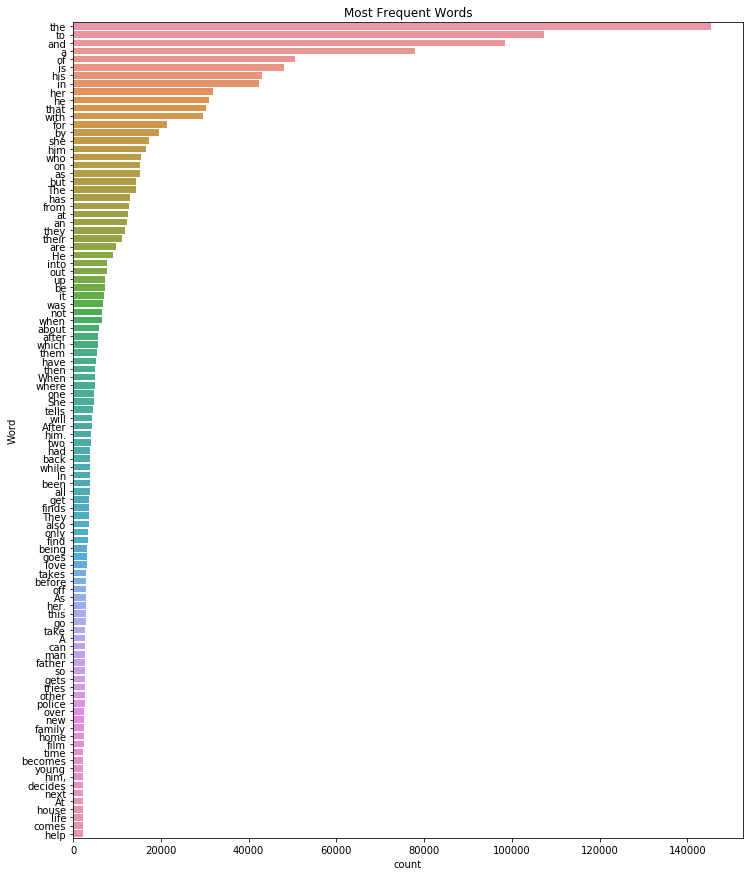

In [914]:
# Word frequencies before normalisation
wordFrequency(df_train['Plot'], 100)

In [915]:
#run the column through the normalizing function
df_train["Plot"] = df_train["Plot"].apply(normalizeText)
df_test["Plot"] = df_test["Plot"].apply(normalizeText) 

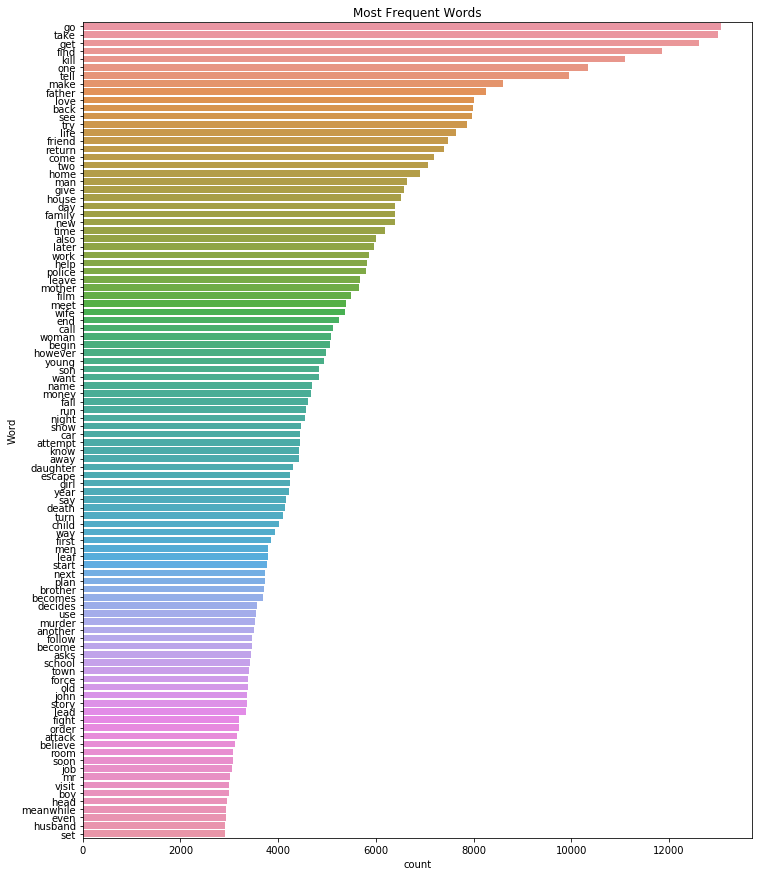

In [893]:
# Word frequencies after normalisation
wordFrequency(df_train['Plot'], 100)

In [894]:
#Creating dataframes with just the plot, and genre of the test and training data

#need to randomize before splitting
df_train = df_train.sample(frac=1)
df_trian = df_train.reset_index(drop=True)
df_test = df_test.sample(frac=1)
df_test = df_test.reset_index(drop=True)

#Setting columns to individual dataframes
train_x = df_train['Plot']
train_y = df_train['Genre']
test_x = df_test['Plot']
test_y = df_test['Genre']

#Prabesh being stupid
#label encoding
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

In [895]:
# Perform tfidf vectorisation on data
tfidf_vec = TfidfVectorizer()
train_x_tfidf = tfidf_vec.fit_transform(train_x)
test_x_tfidf = tfidf_vec.transform(test_x)

In [896]:
# Failed attempt
#model = gensim.models.Word2Vec(train_x, size =100) 
#test_x_w2v = gensim.models.Word2Vec(test_x, size = 100) 
#test_x_w2v

In [897]:
#Prabesh Being stupid < comment>
#want to know what's happening here but can't undersand
#I did log reg in bottom cell. did i do everything you were doing here??
#also what's hamming loss and do we need that??
# also your log reg did better than mine sowhat did you do?? OR maybe not? whats grid search doing??
 
#Grid Search to find the best parameters 
classifier = OneVsRestClassifier(SGDClassifier(loss="log", penalty="l2", class_weight="balanced"))
parameters = { "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0] }

gsv = GridSearchCV(classifier, param_grid=parameters, scoring="f1_micro", n_jobs=-1)
gsv.fit(train_x_tfidf, train_y)

print(gsv.best_score_)
print(gsv.best_params_)
best_alpha = gsv.best_params_['estimator__alpha']

0.62240012557884
{'estimator__alpha': 0.0001}


In [898]:
#PRabesh being studip <comment> 

# Use OneVsRest Classifier with logistic regression as loss function
classifier = OneVsRestClassifier(SGDClassifier(loss="log", alpha=best_alpha, penalty="l2", class_weight="balanced"))
classifier.fit(train_x_tfidf, train_y)
y_pred = classifier.predict(test_x_tfidf)

print("Accuracy:", metrics.accuracy_score(test_y, y_pred))
print("Hamming Loss (number of incorrect labels):", 
      metrics.hamming_loss(test_y, y_pred))


Accuracy: 0.6296644716211979
Hamming Loss (number of incorrect labels): 0.3703355283788021


In [899]:
#model builder
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(predictions, test_y)

In [900]:
# Naive Bayes on TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), train_x_tfidf, train_y, test_x_tfidf)
print("NB TF-IDF: ", accuracy)

# # Naive Bayes on W2V
#accuracy = train_model(naive_bayes.MultinomialNB(), train_x_w2v, train_y, test_x_w2v)
#print("NB W2V: ", accuracy)

NB TF-IDF:  0.40733772342427094


In [901]:
# Logistic Regression on TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), train_x_tfidf, train_y, test_x_tfidf)
print("LR TF-IDF: ", accuracy)

LR TF-IDF:  0.6105362182502352


In [902]:
# SVM on TF IDF Vectors
accuracy = train_model(svm.SVC(kernel='linear'), train_x_tfidf, train_y, test_x_tfidf)
print("SVM-linear TF-IDF : ", accuracy)

SVM-linear TF-IDF :  0.6349952963311383


In [904]:
#SVM radial basis function kernel on TF IDF Vector
accuracy = train_model(svm.SVC(kernel='rbf'), train_x_tfidf, train_y, test_x_tfidf)
print("SVM-rbf TF-IDF : ", accuracy)

SVM-rbf TF-IDF :  0.3740984634681718


In [24]:
## Future work to use Deep learning algorithm such as CNN, RNN - LSTM

# # transfer learning using Google BERT